In [1]:
import wfdb
import pywt
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image

In [2]:
source_dir = './mit-bih-arrhythmia-database-1.0.0/'
target_dir = './arrhythmia_dat'

os.makedirs(target_dir, exist_ok=True)

for file in os.listdir(source_dir):
    if file.endswith('.dat') or file.endswith('.hea'):
        shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

In [3]:
source_dir = './mit-bih-normal-sinus-rhythm-database-1.0.0'
target_dir = './normal_dat'

os.makedirs(target_dir, exist_ok=True)

for file in os.listdir(source_dir):
    if file.endswith('.dat') or file.endswith('.hea'):
        shutil.move(os.path.join(source_dir, file), os.path.join(target_dir, file))

In [4]:
arrhythmia_signals = []

# List of arrhythmic record names (e.g., MIT-BIH arrhythmia patients)
record_list = [i for i in range(100,235)]

for record_name in record_list:
    try:
        record = wfdb.rdrecord(f'./arrhythmia_dat/{record_name}')
        signal = record.p_signal[:, 0]  # Use first lead
    
        # Sampling frequency (usually 360 Hz in MIT-BIH)
        fs = record.fs
    
        # Segment the signal into 2-second windows
        window_size = 2 * fs  # e.g., 720 samples
        for start in range(0, len(signal) - window_size, window_size):
            segment = signal[start:start + window_size]
            arrhythmia_signals.append(segment)
    except FileNotFoundError as e:
        pass

In [5]:
noraml_signals = []

# List of arrhythmic record names (e.g., MIT-BIH arrhythmia patients)
record_list = [i for i in range(16265,19831)]

for record_name in record_list:
    try:
        record = wfdb.rdrecord(f'./normal_dat/{record_name}')
        signal = record.p_signal[:, 0]  # Use first lead
    
        # Sampling frequency (usually 360 Hz in MIT-BIH)
        fs = record.fs
    
        # Segment the signal into 2-second windows
        window_size = 2 * fs  # e.g., 720 samples
        for start in range(0, len(signal) - window_size, window_size):
            segment = signal[start:start + window_size]
            noraml_signals.append(segment)
    except FileNotFoundError as e:
        pass
    except MemoryError as m:
        pass

In [6]:
print(len(arrhythmia_signals))
print(len(noraml_signals))

43296
787470


In [7]:
def generate_scalogram(signal, filename):
    scales = np.arange(1, 128)
    coef, _ = pywt.cwt(signal, scales, 'morl')
    plt.imshow(coef, cmap='jet', aspect='auto')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

In [8]:
sample_paths = [
    './arrhythmia_dat/100.dat',
    './arrhythmia_dat/104.dat',
    './arrhythmia_dat/124.dat',
    './normal_dat/16265.dat',
    './normal_dat/16786.dat',
    './normal_dat/18177.dat',
]

In [9]:
def load_signal(dat_path):
    record_path = dat_path[:-4]
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]
    fs = record.fs
    return signal[:2*fs], fs  # First 2 seconds

def plot_scalogram(signal, fs, title):
    widths = np.arange(1, 129)
    cwtmatr, _ = pywt.cwt(signal, widths, 'morl', sampling_period=1/fs)

    plt.figure(figsize=(6, 3))
    plt.imshow(abs(cwtmatr), extent=[0, 2, 1, 128], cmap='jet', aspect='auto',
               vmax=abs(cwtmatr).max(), vmin=0)
    plt.title(title)
    plt.ylabel('Scale')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Magnitude')
    plt.show()

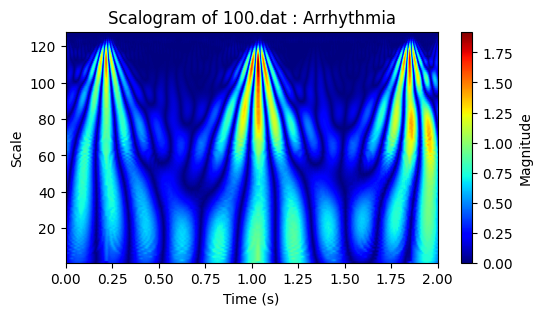

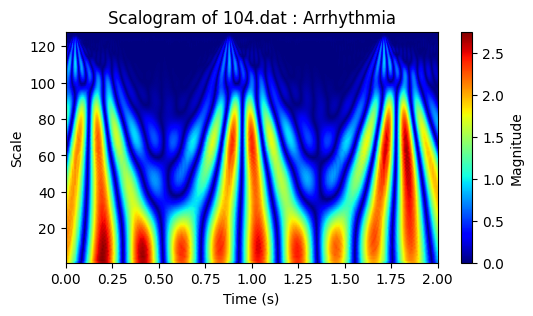

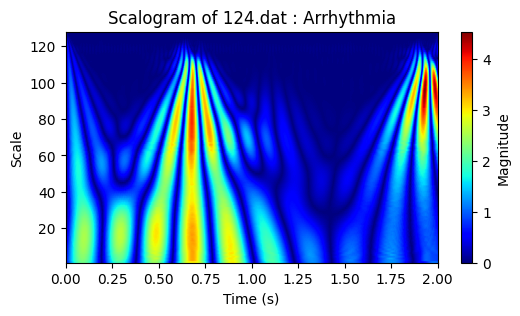

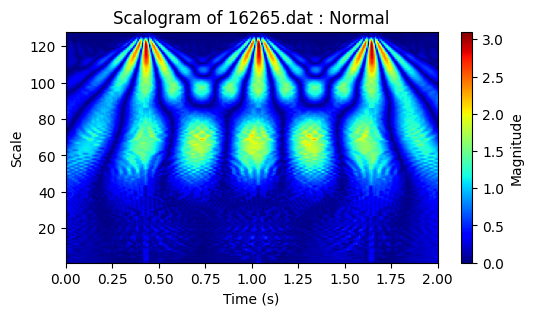

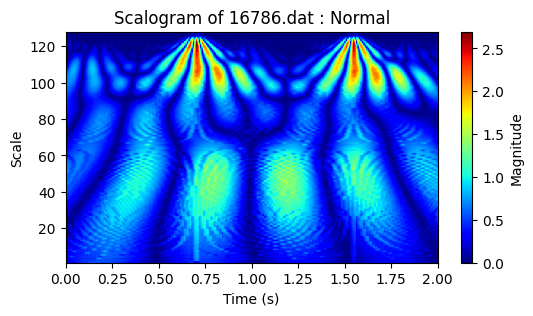

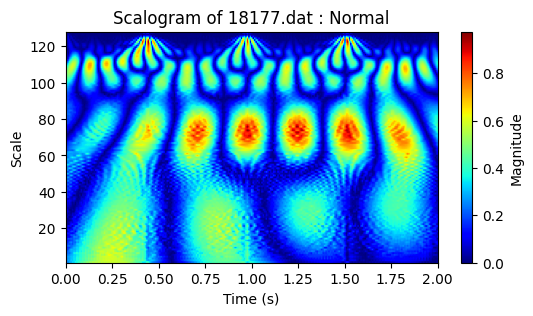

In [10]:
for path in sample_paths:
    signal, fs = load_signal(path)
    if(int(path.split('/')[-1].split('.')[0]) < 290):
        title = "Scalogram of " + path.split('/')[-1] + " : Arrhythmia"
    else:
        title = "Scalogram of " + path.split('/')[-1] + " : Normal"
    plot_scalogram(signal, fs, title)

In [11]:
count = 0
for i, signal in enumerate(arrhythmia_signals):
    count = count+1
    generate_scalogram(signal, f'./cwt_images/arrhythmia/{i}.png')
    if(count == 1200): # to have small dataset
        break

In [12]:
count = 0
for i, signal in enumerate(noraml_signals):
    count = count+1
    generate_scalogram(signal, f'./cwt_images/normal/{i}.png')
    if(count == 1200): # to have small dataset
        break

In [13]:
# to verify if all the images are usable
base_folder = './cwt_images'

for category in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, category)
    if not os.path.isdir(folder_path):
        continue
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        try:
            with Image.open(img_path) as img:
                img.verify()  # Just verify, no need to load full image
        except Exception as e:
            print(f"Bad image detected: {img_path} | Error: {e}")

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

train_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    './cwt_images',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 1920 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [15]:
# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

In [16]:
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_gen, validation_data=val_gen, epochs=3)
model.save('ecg_model.h5')

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9003 - loss: 0.2895 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 2/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 3/3
60/60 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0013


In [18]:
loss, accuracy = model.evaluate(val_gen)
print(f"Test Accuracy: {accuracy*100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 1.0000 - loss: 0.0013
Test Accuracy: 100.00%


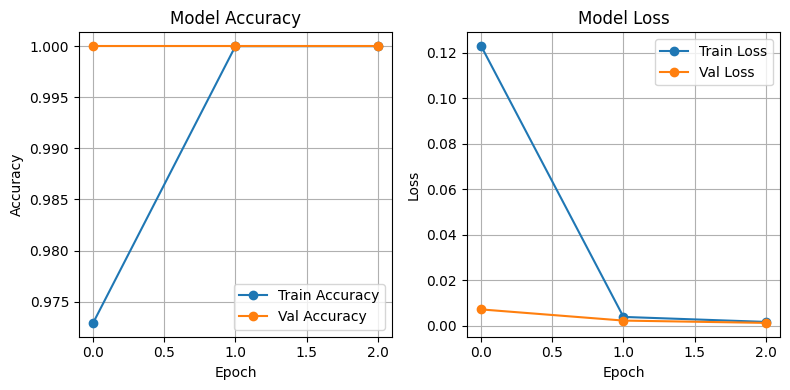

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('training_curves_for_ecg_mmodel.png')

In [20]:
def load_user_signal(folder_path, record_name='sample'):
    record = wfdb.rdrecord(f"{folder_path}/{record_name}")
    signal = record.p_signal[:, 0]  # First lead
    fs = record.fs
    return signal[:2*fs], fs  # First 2 seconds

In [21]:
def predict_heart_condition(model_path, img_path):
    model = load_model(model_path)
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    return "Arrhythmia" if prediction < 0.5 else "Normal"

In [22]:
signal, fs = load_user_signal('./user','./16786')  # Assuming user_ecg.dat/.hea exists
generate_scalogram(signal, 'user_scalogram.png')
result = predict_heart_condition('ecg_model.h5', 'user_scalogram.png')
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Prediction: Normal


In [27]:
def complete_pipeline_1(folder_path,record_name,output_path,model_path):
    signal, fs = load_user_signal(folder_path,record_name)
    generate_scalogram(signal,output_path)
    result = predict_heart_condition(model_path,output_path)
    print("Prediction:", result)

In [28]:
def complete_pipeline(folder_path, record_name, output_path, model_path, true_label):
    signal, fs = load_user_signal(folder_path, record_name)
    generate_scalogram(signal, output_path)
    predicted_label = predict_heart_condition(model_path, output_path)

    # Plot signal with predicted and true label in title
    time = np.linspace(0, 2, len(signal))  # 2 seconds
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, color='black')
    plt.title(f"Predicted: {predicted_label} | True: {true_label}", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("Prediction:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


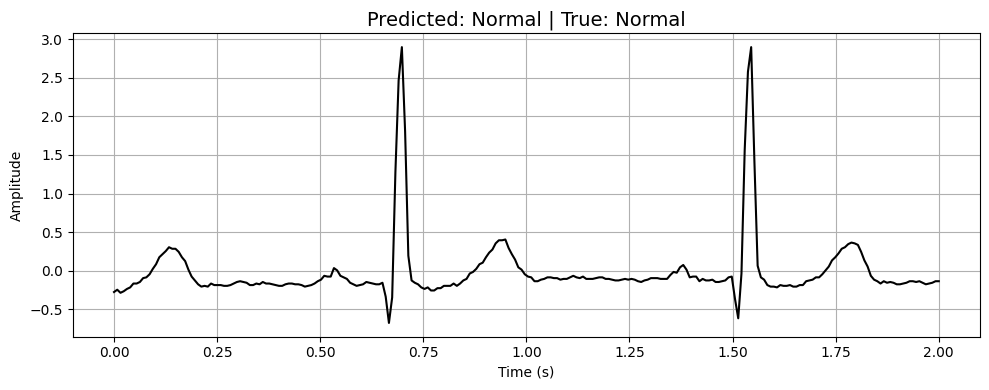

Prediction: Normal


In [29]:
complete_pipeline('./user','16786','user_scalogram.png','ecg_model.h5',true_label='Normal')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


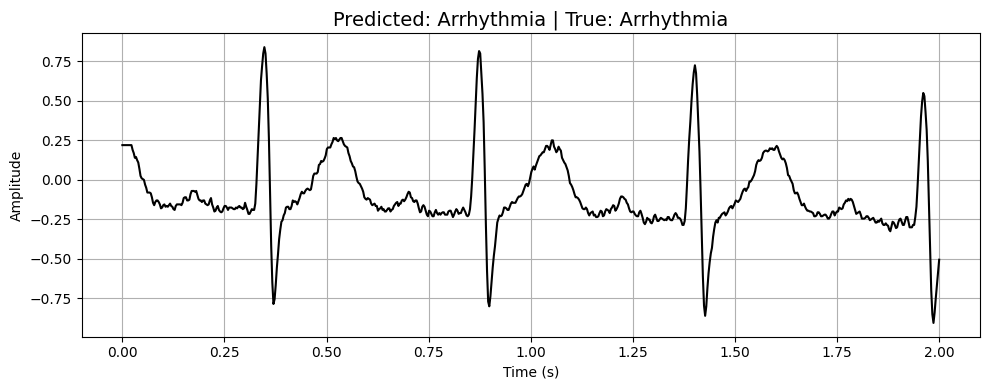

Prediction: Arrhythmia


In [30]:
complete_pipeline('./user','215','user_scalogram.png','ecg_model.h5',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


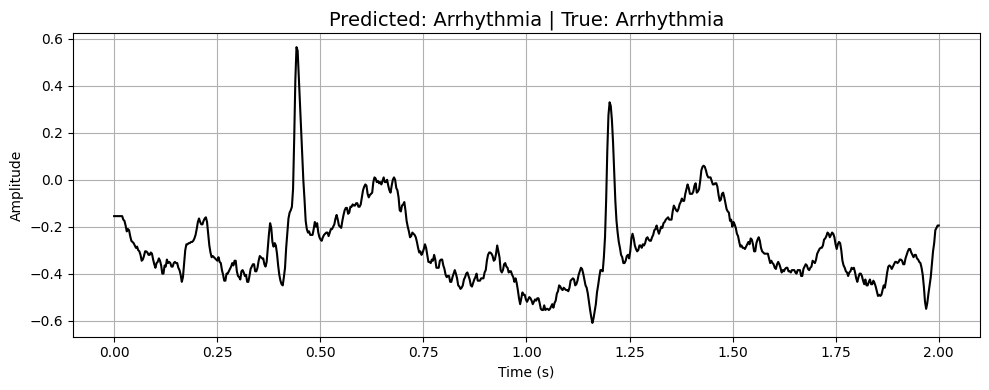

Prediction: Arrhythmia


In [31]:
complete_pipeline('./user','228','user_scalogram.png','ecg_model.h5',true_label='Arrhythmia')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


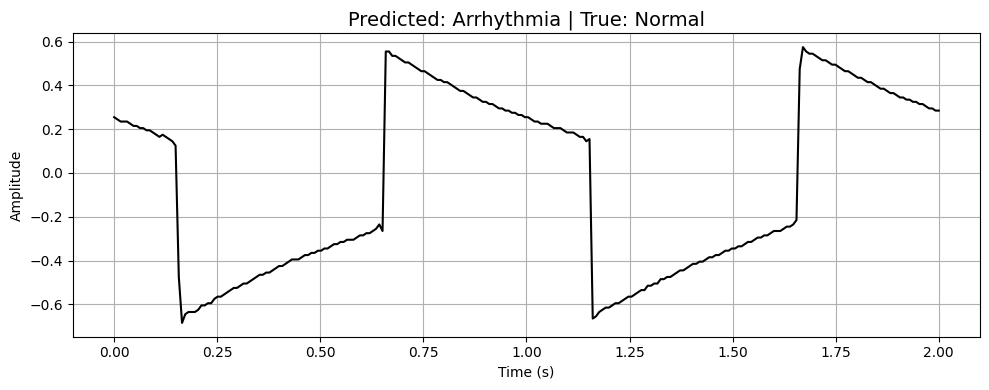

Prediction: Arrhythmia


In [32]:
complete_pipeline('./user','19140','user_scalogram.png','ecg_model.h5',true_label='Normal')

In [33]:
signal, fs = load_user_signal('./user','./19140')  # Assuming user_ecg.dat/.hea exists
generate_scalogram(signal, 'user_scalogram.png')
result = predict_heart_condition('ecg_model.h5', 'user_scalogram.png')
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Prediction: Arrhythmia


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


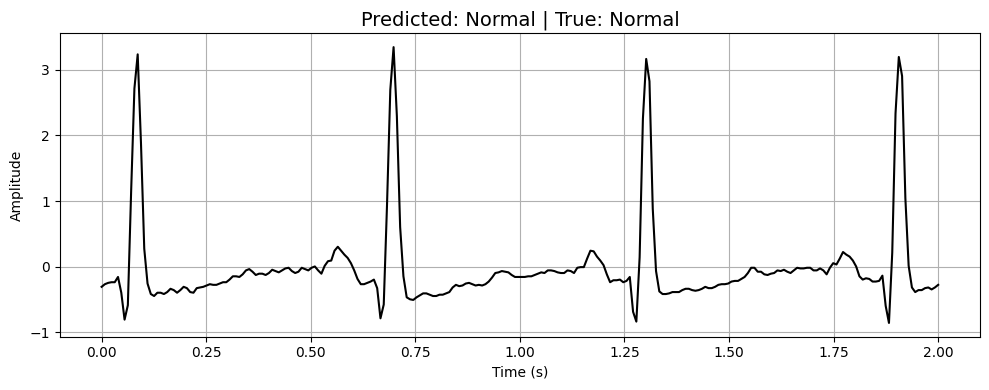

Prediction: Normal


In [34]:
complete_pipeline('./user','16273','user_scalogram.png','ecg_model.h5',true_label='Normal')